In [30]:
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer


In [5]:
df = pd.read_csv(r'../../resources/dataset_amazon_ingles.csv')
df.head()

C:\Users\erik-\AppData\Local\Temp\ipykernel_7960\3382653462.py:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'../../resources/dataset_amazon_ingles.csv')


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,4.0,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,NaN,Shacks
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,NaN,explore42


In [ ]:
df = df[['reviews.rating', 'reviews.text']]
df.head()

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [ ]:
df['sentimiento'] = df['reviews.rating'].map(
    {5.0: 'Positivo',
     4.0: 'Positivo',
     3.0: 'Neutro', 
     2.0: 'Negativo',
     1.0: 'Negativo'
    })

df.head()

In [14]:
round(df.value_counts('sentimiento', normalize=True), 2)

sentimiento
Positivo    0.93
Neutro      0.04
Negativo    0.02
Name: proportion, dtype: float64

In [15]:
df.drop(columns=['reviews.rating'], inplace=True)

In [16]:
df.head()

,reviews.text,sentimiento
0,This product so far has not disappointed. My c...,Positivo
1,great for beginner or experienced person. Boug...,Positivo
2,Inexpensive tablet for him to use and learn on...,Positivo
3,I've had my Fire HD 8 two weeks now and I love...,Positivo
4,I bought this for my grand daughter when she c...,Positivo


In [19]:
df.dropna(inplace=True)

In [20]:
df.isna().sum()

reviews.text    0
sentimiento     0
dtype: int64

In [21]:
corpus_entrenamiento, corpus_prueba, y_entrenamiento, y_prueba = train_test_split(
    df['reviews.text'],
    df['sentimiento'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['sentimiento'])

In [23]:
def print_distribution(name, series):
    series = pd.Series(series)
    dist = round(series.value_counts(normalize=True), 2)
    print(f"{name} Distribution:\n{dist}\n")

# Maintains the original Odyssey/Iliad ratio
print_distribution("Distribución Entrenamiento", y_entrenamiento)
print_distribution("Distribución Prueba", y_prueba)

Distribución Entrenamiento Distribution:
sentimiento
Positivo    0.93
Neutro      0.04
Negativo    0.02
Name: proportion, dtype: float64

Distribución Prueba Distribution:
sentimiento
Positivo    0.93
Neutro      0.04
Negativo    0.02
Name: proportion, dtype: float64



In [37]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')


# Eliminar stopwords y lematizar
stopword_list = set(stopwords.words('english'))

extra_stopwords = {
    "example", "etc", "also","used", "use",
    "one", "two", "like", "br", "much", "cup", "stuff",
    "day", "really", "read", "thing", "mouth",
    "day", "many", "still", "bag",
    "store", "case", "even", "item", "lot", "Amazon",
    "without", "theyre", "soyive", "switchthe", "device"
    
}

stopword_list = stopword_list.union(extra_stopwords)


def procesar_texto_ingles(texto):
    """
    Función para limpiar y preprocesar texto en inglés.
    """
    # Manejo de valores nulos
    if not isinstance(texto, str):
        return ""

    # Eliminar HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()

    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar caracteres no alfabéticos
    texto = re.sub(r"[^a-z\s]", "", texto)

    # Tokenizar
    tokens = word_tokenize(texto, language='english')

    # POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Lematizador
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    # Lematizar correctamente
    tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tags
        if word not in stopword_list and len(word) > 2
    ]

    return ' '.join(tokens)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [35]:
corpus_entrenamiento_normalizado = [procesar_texto_ingles(text) for text in corpus_entrenamiento]
corpus_prueba_normalizado = [procesar_texto_ingles(text) for text in corpus_prueba]

C:\Users\erik-\AppData\Local\Temp\ipykernel_7960\3203202604.py:33: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  texto = BeautifulSoup(texto, "html.parser").get_text()


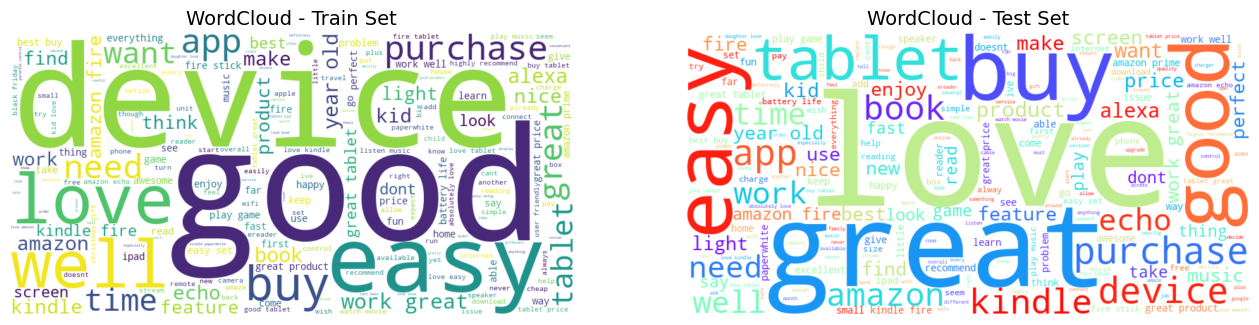

In [36]:
texto_entrenamiento = " ".join(corpus_entrenamiento_normalizado)
texto_prueba = " ".join(corpus_prueba_normalizado)

wc_train = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto_entrenamiento)
wc_test = WordCloud(width=800, height=400, background_color="white", colormap="rainbow").generate(texto_prueba)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_train, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Train Set", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(wc_test, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Test Set", fontsize=14)

plt.show()